### Secure Aggregation

In [1]:
# !pip install phe

In [8]:
import phe
import numpy as np
# Generate Public and Private Key
public_key, private_key = phe.generate_paillier_keypair(n_length=1024)
weight1 = np.random.rand(10)
weight2 = np.random.rand(10)
# Note : This is a simple addition but it can be more complex as well
sum_of_local_weights = np.add(weight1, weight2)
print("Addition Of w1 and w2: " + str(sum_of_local_weights))
encrypted_w1 = [public_key.encrypt(i) for i in weight1]      
encrypted_w2 = [public_key.encrypt(j) for j in weight2] 
encrypted_sum_of_w1_and_w2 = [i+j for i,j in zip(encrypted_w1, encrypted_w2)]                       

decryped_sum_of_w1_and_w2 = [private_key.decrypt(k) for k in encrypted_sum_of_w1_and_w2] 
print("Addition Of Encrypted Number: " + str(decryped_sum_of_w1_and_w2))

Addition Of w1 and w2: [0.89262828 0.33812332 0.54309211 0.2123367  0.45496552 0.70010349
 1.46363787 0.5433867  1.22290087 0.35337987]
Addition Of Encrypted Number: [0.8926282810803743, 0.33812332307203063, 0.5430921091815041, 0.21233669695337742, 0.45496552487219366, 0.7001034860695999, 1.46363787204535, 0.5433866983574012, 1.222900873732598, 0.35337986797106746]


### Tensorflow Federated

In [1]:
import os
import glob
import cv2

BASE_DIR = os.path.join('./Data')
parasitized_dir = os.path.join(BASE_DIR,'Parasitized')
uninfected_dir = os.path.join(BASE_DIR,'Uninfected')

parasitized_files = glob.glob(parasitized_dir+'/*.png')
uninfected_files = glob.glob(uninfected_dir+'/*.png')
len(parasitized_files), len(uninfected_files)

(13779, 13779)

In [ ]:
from joblib import Parallel, delayed
nprocs = os.cpu_count()

In [ ]:
def load_image_shape(img):
    return cv2.imread(img).shape

results = Parallel(n_jobs=nprocs-1)(delayed(load_image_shape)(img_file) for img_file in parasitized_files + uninfected_files)

In [ ]:
print('Min Dimensions:', np.min(results, axis=0)) 
print('Avg Dimensions:', np.mean(results, axis=0))
print('Median Dimensions:', np.median(results, axis=0))
print('Max Dimensions:', np.max(results, axis=0))

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow_federated as tff


In [4]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(BASE_DIR,
                                                               seed=123, 
                                                               labels='inferred', 
                                                               label_mode='int',
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               color_mode='rgb',
                                                               subset="training",
                                                               shuffle=True,
                                                               validation_split = 0.2,
                                                               batch_size= BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(BASE_DIR,
                                                               seed=123, 
                                                               labels='inferred', 
                                                               label_mode='int',
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               color_mode='rgb',
                                                               subset="validation",
                                                               shuffle=True,
                                                               validation_split = 0.2,
                                                               batch_size= BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


In [8]:
NUM_CLIENTS = 10 # Local Nodes
CLIENT_LR = 1e-2
SERVER_LR = 1e-1 # Central Node

In [9]:
NUM_BATCH_CLIENT = int(len(train_ds)/NUM_CLIENTS)

In [10]:
import collections
client_train_dataset = collections.OrderedDict()
skip = 0
try :
    for i in range(1, NUM_CLIENTS+1):
        client_name = "Client_" + str(i)
        take = NUM_BATCH_CLIENT
        client_data = train_ds.skip(skip).take(take) 
        x_train, y_train = zip(*client_data)
        
        # For memory management taking only 3 clients
        if i > 3:
            NUM_CLIENTS = i-1
            break

        print(f"Adding data from Batch No {skip} to {take*i} for client : {client_name}")

        # We are going to unbatch and load the data to prevent data dropping in creating client data later on
        data = collections.OrderedDict((('label', 
                                         [y for x in y_train for y in x]), 
                                        ('pixels', [y for x in x_train for y in x])))
#         data = collections.OrderedDict((('label', (y for x in y_train for y in x), 
#                                         ('pixels', (y for x in x_train for y in x)))))
        client_train_dataset[client_name] = data
        skip = take*i
        
except Exception as e:
    print(e)
    print("Memory Error - Client Data creation stopped")
    print(f"Total number of clients created are {len(client_train_dataset)}")
    NUM_CLIENTS = len(client_train_dataset)

Adding data from Batch No 0 to 68 for client : Client_1
Adding data from Batch No 68 to 136 for client : Client_2
Adding data from Batch No 136 to 204 for client : Client_3


In [11]:
del x_train

In [12]:
train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

In [46]:
import collections
client_test_dataset = collections.OrderedDict()
skip = 0
try :
    for i in range(1, NUM_CLIENTS+1):
        client_name = "Client_" + str(i)
        take = NUM_BATCH_CLIENT
        client_data = val_ds.skip(skip).take(take) 
        x_val, y_val = zip(*client_data)
        
        # For memory management taking only 3 clients
        if i > 3:
            NUM_CLIENTS = i-1
            break

        print(f"Adding data from Batch No {skip} to {take*i} for client : {client_name}")

        # We are going to unbatch and load the data to prevent data dropping in creating client data later on
        data = collections.OrderedDict((('label', 
                                         [y for x in y_val for y in x]), 
                                        ('pixels', [y for x in x_val for y in x])))
        client_test_dataset[client_name] = data
        skip = take*i
        
except Exception as e:
    print(e)
    print("Memory Error - Client Data creation stopped")
    print(f"Total number of clients created are {len(client_test_dataset)}")
    NUM_CLIENTS = len(client_test_dataset)

Adding data from Batch No 0 to 68 for client : Client_1
Adding data from Batch No 68 to 136 for client : Client_2
Adding data from Batch No 136 to 204 for client : Client_3


In [13]:
del client_train_dataset

In [14]:
sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])
sample_element = next(iter(sample_dataset))

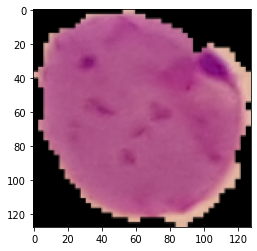

In [15]:
plt.imshow(sample_element['pixels'].numpy().astype('uint8'))
plt.grid(False)
plt.show()

In [16]:
SHUFFLE_BUFFER = len(sample_dataset) # How much data to shuffle
EPOCHS = 5 # Number of epochs to run for training @ individual node
PREFETCH_BUFFER = 100 # Preloading some number of samples to aid faster training.

# Normalizing the pixel values
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)

def preprocess(dataset):

    def batch(sample):
        _x = normalization_layer(sample['pixels'])
        return collections.OrderedDict(
            x = _x,
            y = tf.reshape(sample['label'], [-1, 1]))

    return dataset.repeat(EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
          BATCH_SIZE).map(batch).prefetch(PREFETCH_BUFFER)

In [17]:
selected_clients = np.random.choice(train_dataset.client_ids,2, replace = False)

In [18]:
federated_train_data = [preprocess(train_dataset.create_tf_dataset_for_client(i)) for i in selected_clients]

In [19]:
sample_federated_dataset = preprocess(sample_dataset)

In [20]:
# np.expand_dims(sample_element['pixels'].numpy(), axis = -1)

In [21]:
# sample_element['label'].numpy().reshape([-1,1])

In [22]:
def train_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
        # Ingesting a 2-d Image with 3 channels
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        # Max pooling to reduce dimensions
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        # Dropout to prevent over-fitting
        tf.keras.layers.Dropout(0.2),
        # Flattening to feed data for sigmoid activation
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    return model

In [23]:
def federated_train_model():
    local_train_model = train_model()
    return tff.learning.from_keras_model(
        local_train_model,
        input_spec=sample_federated_dataset.element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC()])

In [24]:
parameter_iteration_process = tff.learning.build_federated_averaging_process(
    federated_train_model,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate= CLIENT_LR),
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate= SERVER_LR))

In [25]:
str(parameter_iteration_process.initialize.type_signature)

'( -> <model=<trainable=<float32[3,3,3,16],float32[16],float32[3,3,16,32],float32[32],float32[3,3,32,64],float32[64],float32[16384,128],float32[128],float32[128,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [26]:
# !pip install --quiet --upgrade --user nest_asyncio

In [27]:
import nest_asyncio
nest_asyncio.apply()

In [28]:
state = parameter_iteration_process.initialize()

In [29]:
state, metrics = parameter_iteration_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('auc', 0.5897039), ('loss', 0.6823319)]))])


In [30]:
NUM_ROUNDS = 6 # Total 5 rounds of training
for round_num in range(2, NUM_ROUNDS):
    state, metrics = parameter_iteration_process.next(state, federated_train_data)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('auc', 0.60388386), ('loss', 0.67804503)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('auc', 0.61434853), ('loss', 0.6752475)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('auc', 0.62443274), ('loss', 0.67076266)]))])
round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('auc', 0.6333971), ('loss', 0.6674127)]))])


## Evaluation

In [39]:
def evaluate(train_fn, state, train_data, test_data):
    
    # Print training metrics
    evaluation = tff.learning.build_federated_evaluation(train_fn)
    train_metrics = evaluation(state.model, train_data)
    print("Training Metrics: AUC : {}, Binary Cross Entropy Loss: {}".format(
        train_metrics['auc'],
        train_metrics['loss']))
    
    # Print testing metrics
    test_metrics = evaluation(state.model, test_data)
    print("Validation Metrics:  AUC: {}, Binary Cross Entropy Loss: {}".format(
        test_metrics['auc'],
        test_metrics['loss']))

In [49]:
val_dataset  = tff.simulation.FromTensorSlicesClientData(client_test_dataset)
federated_val_data = [preprocess(val_dataset.create_tf_dataset_for_client(i)) for i in selected_clients]

In [50]:
evaluate(federated_train_model, state, federated_train_data, federated_val_data)

Training Metrics: AUC : 0.6697379946708679, Binary Cross Entropy Loss: 0.6773737072944641
Validation Metrics:  AUC: 0.6535744071006775, Binary Cross Entropy Loss: 0.6790395379066467
